## Perspective Projection or Homography Estimation

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.io as sio
import skimage.io as io
from PIL import Image
import cv2
import matplotlib.image as mpimg
from matplotlib import path

Randomly visualise images from the directory

In [17]:
import glob
import os
import random

In [66]:
IMG_DIR = "images/barcaReal/"

img_paths = glob.glob(os.path.join(IMG_DIR, "*"))
img_paths.sort()
random_img_path = random.choice(img_paths)
random_img = io.imread(random_img_path)

Number of video frames : 129


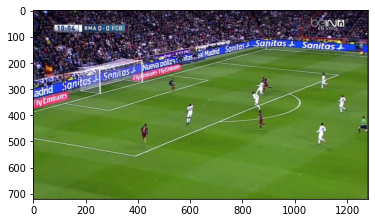

In [67]:
print("Number of video frames : {}".format(len(img_paths)))
plt.imshow(random_img)

Load the logo and points on the logo

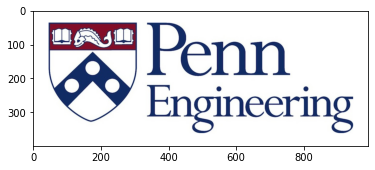

In [68]:
logo_img = io.imread("images/logos/penn_engineering_logo.png")

h,w,_ = logo_img.shape
logo_pts = [[0,0], [0,w], [h,w], [h,0]]

plt.imshow(logo_img)

Load the video and videopoints of the goal stations and form a meshgrid of points

In [69]:
dirdata = "data/BarcaReal_pts.mat"
video_pts = sio.loadmat(dirdata)['video_pts']

In [70]:
num_ima = video_pts.shape[2]
test_images = np.linspace(1,num_ima,num_ima).astype(int)

In [122]:
H, W, _ = random_img.shape
print(H,W)

720 1280


In [153]:
def filter_interior_points(img_size, corner_pts):
    
    H,W = img_size
    x,y = np.meshgrid(np.linspace(1,W,W), np.linspace(1,H,H))
    
    #form a polygon path to around the corners points of the goal
    p = path.Path(corner_pts) 
    
    # stack all points from the meshrid into (Nx2) shape
    all_pts = np.hstack((x.flatten()[:,np.newaxis],y.flatten()[:,np.newaxis]))
    
    # generate a flag operator to determine whether each point is inside : (N,1) shape
    flags = p.contains_points(allpts)
    
    return allpts[flags,:]

In [185]:
random_num = random.randint(0,len(img_paths)-1)

random_img_path = img_paths[random_num]
random_img_corner_pts = video_pts[:,:,random_num]

random_img = io.imread(random_img_path)
random_img_size = random_img.shape[0], random_img.shape[1]

goal_interior_pts = filter_interior_points(random_img_size, random_img_corner_pts)

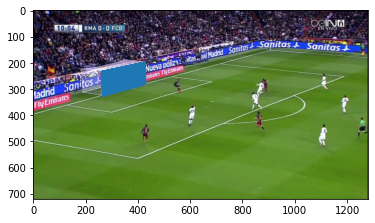

In [187]:
plt.imshow(random_img)
plt.plot(goal_interior_pts[:,0], goal_interior_pts[:,1])

Solving for Homography Equation

In [214]:
# A is 2n x 9 matrix for solving the set of homography equations 
# It is solved by Singular Value Decomposition

from numpy import linalg

def vectorize(p,q):
    x1=p[0]
    x2=p[1]
    x_1 = q[0]
    x_2 = q[0]
    
    return [[-x1, -x2, -1, 0, 0, 0, x1*x_1, x2*x_1, x_1],
            [0, 0 , 0, -x1, -x2, -1, x1*x_2, x2*x_2, x_2]]

def solve_homography(points_p, points_q):
    """
    Solves the homography equation using the set of equation that maps a set of points
    p = (p1,p2,1) to another set of points q = (q1, q2, 1) such that q ~ Hp
    """
    
    assert len(points_p)==4
    assert len(points_q)==4
    
    A = []
    
    for p,q in zip(points_p,points_q):
        A.extend(vectorize(p,q))
    
    # solving a set of equations such that Ah=0 and h = flatten(H)
    U,s,V = linalg.svd(A)
    
    #The vector h will then be the last column of V
    H = V[:,-1].reshape(3,3)
    
    return H    

In [215]:
# Here we are solving for homography matrix such that
# logo_points ~ H * video points

H = solve_homography(random_img_corner_pts, logo_pts)

In [219]:
def inverse_warp( img_final, img_initial, pts_final, pts_initial ):
    """
        inverse_warping takes two images and a set of correspondences between
        them, and warps all the pts_initial in img_initial to the pts_final in
    """
    
    pass